##### STAT 301 - Statistical Modelling for Data Science
## Project on Housing Market Trend Prediction in California
#### Final Report
##### Group 5: Zhengling Jiang, Jenny Lee, Shuhao Zhang, Lorraine Luo

In [37]:
library(dplyr)
library(ggplot2)
library(GGally)
library(tidyverse)
library(caret)
library(glmnet)
library(car)
library(broom)
library(tidyr)
library(leaps)
library(mltools)
library(gridExtra)

## Introduction

California's housing market, known for its complexity and diversity, presents unique challenges for predictive modeling. This study aims to predict housing values in this market, focusing on factors like median age, rooms, bedrooms, population, households, median income, and ocean proximity. According to Federal Reserve Bank of Chicago (2018), neighborhoods, particularly emphasizing property characteristics and geographic variables, may have a relationship with the housing value. This research provides valuable insights into how similar variables can influence housing prices, offering a pertinent context for our analysis in California. The impact of natural landscape features like ocean proximity on property values is also a popular topic in real estate market (Shi et al, 2022). Our study seeks to use the data set from Kaggle to examine the prediction question: **How well can the housing values be predicted using factors such as the median housing age, the total number of rooms and bedrooms, the total number of residents and households, the median income of households, and the ocean proximity? Among these, which variables serve as the most influential predictors for the median house value? And how accurately can we build a predictive model for housing values using these variables?**

The dataset is derived from the 1990 California Census. The dataset provides detailed information about houses in various districts in California, based on the 1990 California Census created and published by the Census Bureau of the United States and USGS (United States Geological Survey) in 1992. The dataset contains a total number of 10 variables and 20640 observations. In this project, we will use linear regression and LASSO models to conduct a prediction study.

Dataset Link: https://www.kaggle.com/datasets/camnugent/california-housing-prices

## Methods and Results

### Exploratory Data Analysis (EDA)

#### Load Data

In [38]:
urlfile="https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv"

housing <- read.csv(urlfile)
head(housing)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY
2,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY
3,-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY
4,-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY
5,-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY
6,-122.25,37.85,52,919,213,413,193,4.0368,269700,NEAR BAY


**Explanatory Variables (Features):** <br>
1. longitude: A measure of how far west a house is; a higher value is farther west [**Numeric**]
2. latitude: A measure of how far north a house is; a higher value is farther north [**Numeric**]
3. housingMedianAge: Indicates the median age of houses within a block. [**Numeric**]
4. totalRooms: Aggregate number of rooms across all houses in a block.  [**Numeric**]
5. totalBedrooms: Aggregate number of bedrooms across all houses in a block. [**Numeric**]
6. population: Total number of people residing within a block [**Numeric**]
7. households: Number of individual households within a block. A household refers to a group of people living in a single home unit.  [**Numeric**]
8. medianIncome: Median income of households in a block, represented in tens of thousands of US Dollars.  [**Numeric**]
9. oceanProximity: Categorizes a block's proximity to the ocean. Possible values: 'NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'. [**Categorical**]

**Response Variable (Target):** <br>
medianHouseValue: Median house value for households within a **block** (measured in US Dollars) [**Numeric**]

**Note:** All the data were collected at the block level. A "block" is a land area bounded by streets or other boundaries in a city. It contains multiple households. In this dataset, each observation aggregates data for all households within a single block. 

#### Clean and Wrangle Data

The original dataset included longitude and latitude values. However, we excluded them due to non-unique coordinates across blocks and the limited interpretability these values offer for housing price predictions. Instead, we prioritized features that more directly relate to housing characteristics and regional factors.

In [39]:
summary(housing)

   longitude         latitude     housing_median_age  total_rooms   
 Min.   :-124.3   Min.   :32.54   Min.   : 1.00      Min.   :    2  
 1st Qu.:-121.8   1st Qu.:33.93   1st Qu.:18.00      1st Qu.: 1448  
 Median :-118.5   Median :34.26   Median :29.00      Median : 2127  
 Mean   :-119.6   Mean   :35.63   Mean   :28.64      Mean   : 2636  
 3rd Qu.:-118.0   3rd Qu.:37.71   3rd Qu.:37.00      3rd Qu.: 3148  
 Max.   :-114.3   Max.   :41.95   Max.   :52.00      Max.   :39320  
                                                                    
 total_bedrooms     population      households     median_income    
 Min.   :   1.0   Min.   :    3   Min.   :   1.0   Min.   : 0.4999  
 1st Qu.: 296.0   1st Qu.:  787   1st Qu.: 280.0   1st Qu.: 2.5634  
 Median : 435.0   Median : 1166   Median : 409.0   Median : 3.5348  
 Mean   : 537.9   Mean   : 1425   Mean   : 499.5   Mean   : 3.8707  
 3rd Qu.: 647.0   3rd Qu.: 1725   3rd Qu.: 605.0   3rd Qu.: 4.7432  
 Max.   :6445.0   Max.   :35682   

We find that there are missing values in our dataset. Dealing with this problem is our first job.

In [40]:
# check NA
sum(is.na(housing))

[1] 207

There are 207 missing values.

In [41]:
# check NA for categorical feature
sum(is.na(housing$ocean_proximity))

[1] 0

There is no missing value for categorical feature. Therefore, I only need to replace the missing value with mean for numeric variables.

In [42]:
# replace missing value with mean for numeric variables
housing <- housing %>%
  mutate_at(vars(1:9), ~ifelse(is.na(.), mean(., na.rm = TRUE), .))

In [43]:
# check NA again
sum(is.na(housing))

[1] 0

The dataset has no missing value now. Next, I want to remove 'longitude' and 'latitude' from the dataset.

In [44]:
housing <- housing %>%
    select(-longitude, -latitude)

head(housing)

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,41,880,129,322,126,8.3252,452600,NEAR BAY
2,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY
3,52,1467,190,496,177,7.2574,352100,NEAR BAY
4,52,1274,235,558,219,5.6431,341300,NEAR BAY
5,52,1627,280,565,259,3.8462,342200,NEAR BAY
6,52,919,213,413,193,4.0368,269700,NEAR BAY


After our data wrangling process, the dataset is now in a tidy format.

#### Visualization

We want to explore the association between variables. ggparis() function is a good choice and it will generate a pair plot of all variables. It can show us pairwise scatterplots, boxplots, histograms, density plots, and correlation coefficients. It helps us understand potential correlations, distributions, and how categorical variables might impact numeric ones. (We are using only 10 percent of the population to apply ggpairs() for plotting since the population is too large to use the function.)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


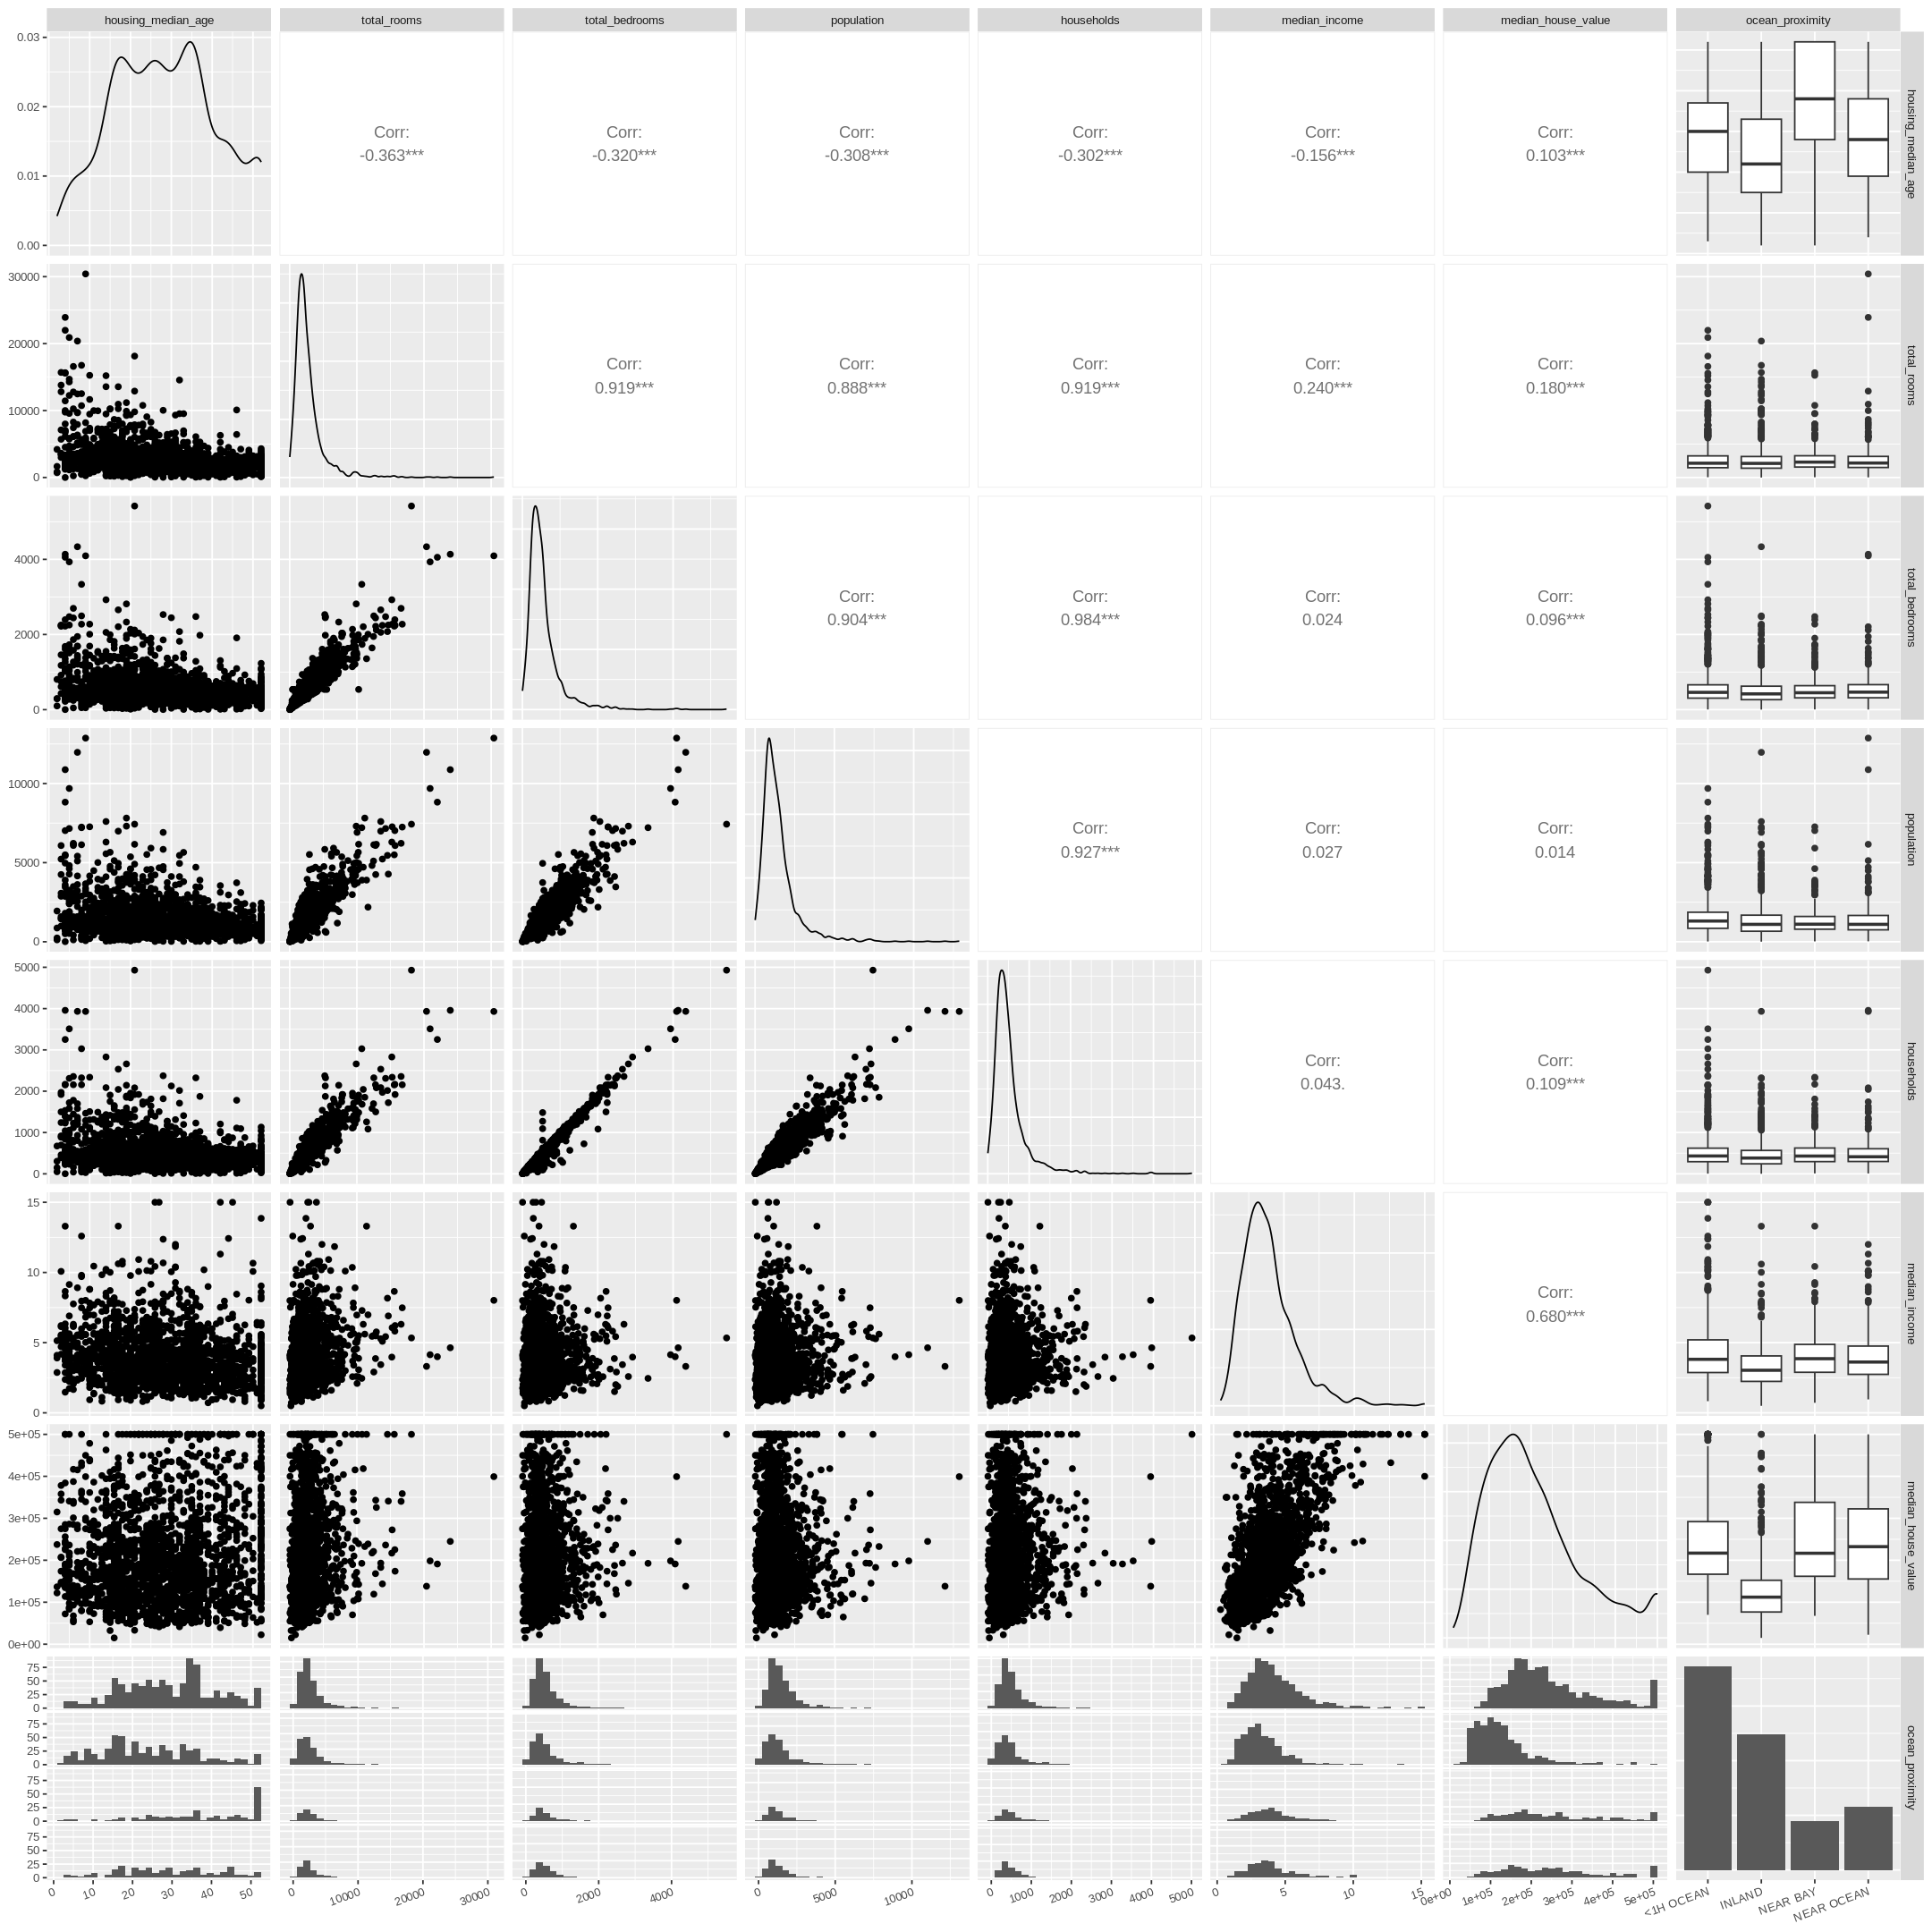

In [45]:
options(repr.plot.width = 18, repr.plot.height = 18)

set.seed(123)
sampled_housing <- housing[sample(nrow(housing), nrow(housing)*0.1), ]

pair_plots <- sampled_housing %>%
     ggpairs(progress = FALSE) +
theme(
     text = element_text(size = 10),
     plot.title = element_text(face = "bold"),
     axis.title = element_text(face = "bold"),
     axis.text.x = element_text(angle = 20, hjust = 1)
)
pair_plots

- Variable Distributions: Right-skewed distributions noted for 'total_bedrooms', 'total_rooms', 'population', and 'median_income'. 'Housing_median_age' showed multiple peaks, with a significant one beyond the median. 'Median_house_value' appeared bimodal with a distinct upper limit peak. 'Ocean_proximity' frequencies were uneven, with '<1H OCEAN' and 'INLAND' being more common.

- Histograms: These illustrated the numeric variable distributions across 'ocean_proximity' categories, essential for understanding category-specific trends.

- Boxplots: The boxplot at the right of the ggparis() plot shows the interquartile range (IQR) of numeric variables, segmented by 'ocean_proximity' levels. Focusing on the "medianHouseValue" boxplot is particularly useful. We can see from the boxplot that 'INLAND' has the lowest median value, 'ISLAND' has the highest median value, and others have the similar median value. It is obvious that 'INLAND' has many outliers above the box, which may indicate that even within the 'INLAND' category, there can be diverse geographic or environmental features that can make certain areas more desirable.

- Scatter Plots: We can find that 'total_rooms' has strong correlation with 'total_bedrooms', 'population' and 'households'. 'total_bedrooms' has strong correlation with 'population' and 'households'. 'Population' has strong correlation with 'households'. We need to concern about these variables when we build regression model because these variables may be multicollinear.

- Correlation Coefficients: Quantified the relationships seen in scatter plots, confirming strong positive correlations (such as total_rooms and total_bedrooms which has a correlation coefficient of approximately 0.92) and informing us of multicollinearity that must be accounted for to ensure robust modeling.

This comprehensive visual analysis will guide the refinement of our predictive models by highlighting influential variables and potential data intricacies.

For further analysis, we can create additional scatterplots to detect any linear association between each explanatory variable and the response variable. The points have been colored differently according to the ocean proximity variable.

In [46]:
# scatterplots, colored by ocean proximity
options(repr.plot.width = 16, repr.plot.height = 12)

# median house value vs. median house age
y_housing_median_age_plot <- housing |>
    ggplot(aes(x = housing_median_age, y = median_house_value, color = ocean_proximity)) +
    geom_point(alpha = 0.5, size = 1) +
    labs(x = "Median House Age (in years)",
         y = "Median House Value (in USD)",
         color = "Ocean Proximity",
         title = "Median House Value vs. Median House Age") +
    theme_bw() +
    theme(text = element_text(size = 15))

# median house value vs. total number of rooms
y_total_rooms_plot <- housing |>
    ggplot(aes(x = total_rooms, y = median_house_value, color = ocean_proximity)) +
    geom_point(alpha = 0.5, size = 1) +
    labs(x = "Total number of rooms in the block",
         y = "Median House Value (in USD)",
         color = "Ocean Proximity",
         title = "Median House Value vs. Total Number of Rooms") +
    theme_bw() +
    theme(text = element_text(size = 15))

# median house value vs. total number of bedrooms
y_total_bedrooms_plot <- housing |>
    ggplot(aes(x = total_bedrooms, y = median_house_value, color = ocean_proximity)) +
    geom_point(alpha = 0.5, size = 1) +
    labs(x = "Total number of bedrooms in the block",
         y = "Median House Value (in USD)",
         color = "Ocean Proximity",
         title = "Median House Value vs. Total Number of Bedrooms") +
    theme_bw() +
    theme(text = element_text(size = 15))

# median house value vs. total population
y_population_plot <- housing |>
    ggplot(aes(x = population, y = median_house_value, color = ocean_proximity)) +
    geom_point(alpha = 0.5, size = 1) +
    labs(x = "Total population in the block",
         y = "Median House Value (in USD)",
         color = "Ocean Proximity",
         title = "Median House Value vs. Total Population") +
    theme_bw() +
    theme(text = element_text(size = 15))

# median house value vs. total number of households
y_households_plot <- housing |>
    ggplot(aes(x = households, y = median_house_value, color = ocean_proximity)) +
    geom_point(alpha = 0.5, size = 1) +
    labs(x = "Total number of households in the block",
         y = "Median House Value (in USD)",
         color = "Ocean Proximity",
         title = "Median House Value vs. Total Number of Households") +
    theme_bw() +
    theme(text = element_text(size = 15))

# median house value vs. median income
y_median_income_plot <- housing |>
    ggplot(aes(x = median_income, y = median_house_value, color = ocean_proximity)) +
    geom_point(alpha = 0.5, size = 1) +
    labs(x = "Median household income in the block (in USD 10,000)",
         y = "Median House Value (in USD)",
         color = "Ocean Proximity",
         title = "Median House Value vs. Median Household Income") +
    theme_bw() +
    theme(text = element_text(size = 15))

In [47]:
# The following code shows the image below
# grid.arrange(y_housing_median_age_plot, y_total_rooms_plot,
#              y_total_bedrooms_plot, y_population_plot, 
#              y_households_plot, y_median_income_plot, ncol = 2)

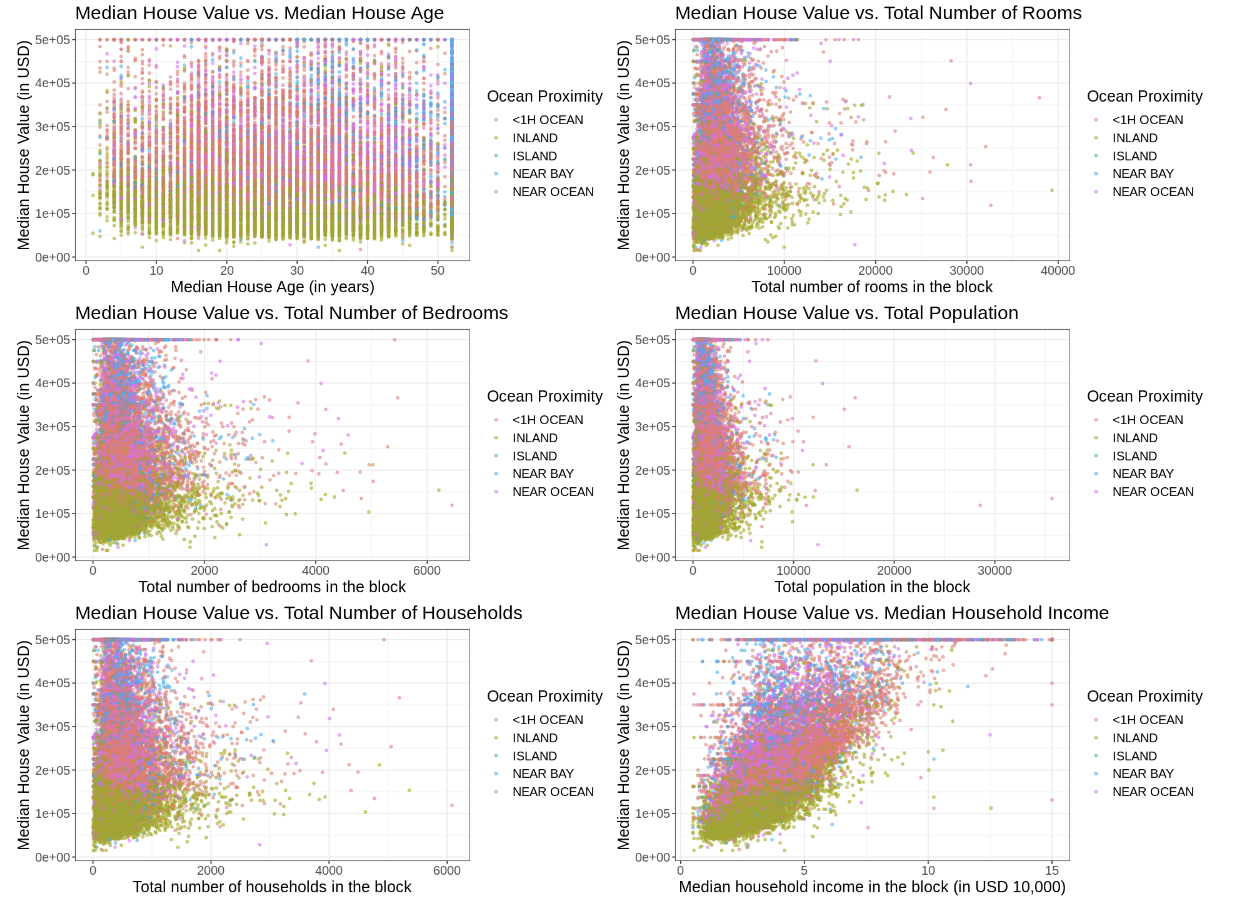

All scatterplots show that the houses located inland are associated with low median house values, while those located near the bay are associated with high median house values. It is hard to identify the linear association between the response and the median house age within a block, but the plot clearly shows that there exists a relationship between ocean proximity and the median house value. Since the distribution of many variables is right-skewed, it is difficult to determine the relationship between the response and some explanatory variables, such as the total number of rooms, bedrooms, residents, and households within a block. It appears that there is a positive linear association between most explanatory variables and the median house value regardless of ocean proximity, but to confirm if it is suitable to use the linear regression model, we need to check several assumptions.

### Linear Regression Model Assumption Checkings

In [48]:
housing_full_model <- lm(median_house_value ~., data = housing)
housing_full_model_results <- tidy(housing_full_model, conf.int = TRUE) %>% mutate_if(is.numeric, round, 2)
housing_full_model_results

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),27871.38,2447.16,11.39,0.00,23074.76,32668.00
housing_median_age,1170.52,44.19,26.49,0.00,1083.90,1257.15
total_rooms,-6.30,0.78,-8.07,0.00,-7.83,-4.77
total_bedrooms,57.95,6.04,9.60,0.00,46.12,69.78
population,-38.11,1.08,-35.44,0.00,-40.22,-36.01
households,99.25,6.73,14.74,0.00,86.05,112.45
median_income,40037.68,334.02,119.87,0.00,39382.99,40692.38
ocean_proximityINLAND,-68149.29,1252.42,-54.41,0.00,-70604.12,-65694.45
ocean_proximityISLAND,176620.85,31261.91,5.65,0.00,115345.03,237896.67


So far, we are not going to interpret the computed results yet since our purpose is to check the heteroscedasticity and normality of data. To detect heteroscedasticity, we can look at residuals-fitted value plots for diagnosis. To see normality, we can use the Q-Q plot.

#### Check Heteroscedasticity and Normality

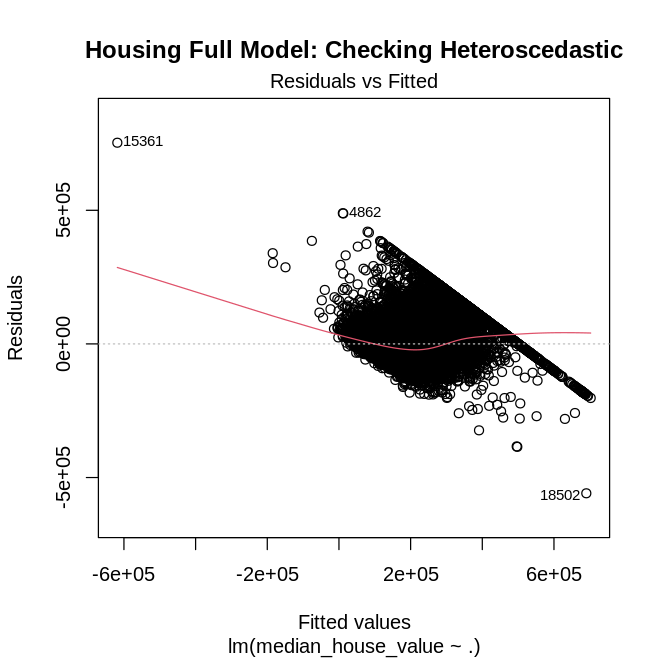

In [49]:
options(repr.plot.width = 5.5, repr.plot.height = 5.5)
plot(housing_full_model, 1, main = "Housing Full Model: Checking Heteroscedastic")

In the fitted values vs residuals plot, the point are not uniformly distributed, and this means the variances are not equal. Thus, we will use log() function to transform data.

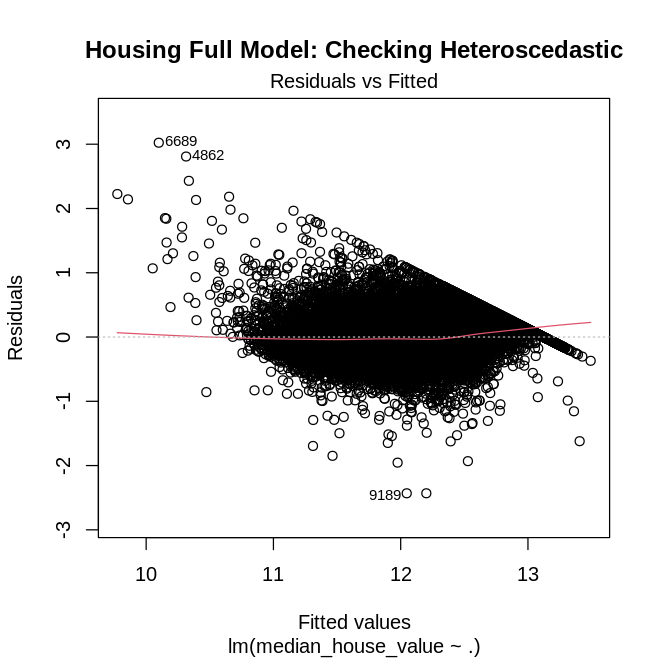

In [50]:
log_housing <- housing %>%
  mutate(across(where(is.numeric), log))

housing_full_model <- lm(median_house_value ~., data = log_housing)
plot(housing_full_model, 1, main = "Housing Full Model: Checking Heteroscedastic")

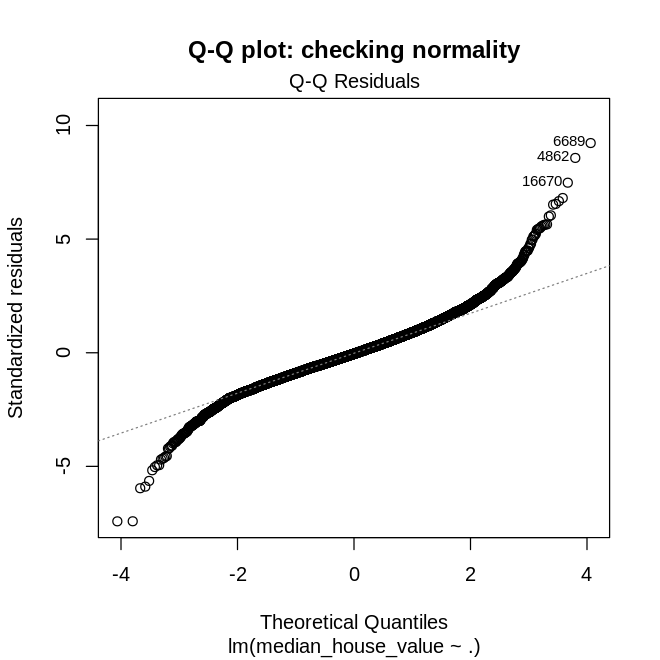

In [51]:
plot(housing_full_model, 2, main = "Q-Q plot: checking normality")

From the above plots, we can see the heteroscedastic and normality are almost satisfied after log transformation. There are still some outliers due to the large size of our data.

#### Check Multicollinearity using Variation Inflation Factors (VIF)

In [52]:
round(vif(housing_full_model),3)

,GVIF,Df,GVIF^(1/(2*Df))
housing_median_age,1.239,1,1.113
total_rooms,21.917,1,4.682
total_bedrooms,28.427,1,5.332
population,8.161,1,2.857
households,28.501,1,5.339
median_income,2.553,1,1.598
ocean_proximity,1.515,4,1.053


By observing the VIFs, we can notice that some of the input variables are highly correlated (such as `total_rooms` and `total_bedrooms` which has a correlation coefficient of approximately 0.92), and this will lead to multicollinearity, a problem for the least square estimates of the linear regression coefficients, as well as for their standard errors.

In [53]:
# TO BE EDITED
# corr_matrix_housing <- log_housing %>%
#    select(- median_house_value, -total_rooms, -total_bedrooms, -population, -log_median_house_value, -log_longitude, -log_latitude, -households,-median_house_value,-housing_median_age) %>%
#    cor() %>%
#    as.data.frame() %>%
#    rownames_to_column("var1") %>%
#    pivot_longer(- var1, names_to = "var2", values_to = "corr")
# head(corr_matrix_housing)

corr_matrix_housing <- log_housing %>%
   select(-median_house_value, -ocean_proximity) %>% # excluding response and non-continuous input variables
   cor() %>%
   as.data.frame() %>%
   rownames_to_column("var1") %>%
   pivot_longer(- var1, names_to = "var2", values_to = "corr")
head(corr_matrix_housing)

var1,var2,corr
<chr>,<chr>,<dbl>
housing_median_age,housing_median_age,1.0000000
housing_median_age,total_rooms,-0.3037577
housing_median_age,total_bedrooms,-0.2576854
housing_median_age,population,-0.2233150
housing_median_age,households,-0.2284824
housing_median_age,median_income,-0.1521043


To create a correlation matrix on top of a heatmap using corr_matrix_housing, we can use geom_tile() function from ggplot2 and round the correlation coefficients to 2 decimal places. We call this plot plot_corr_matrix_housing.

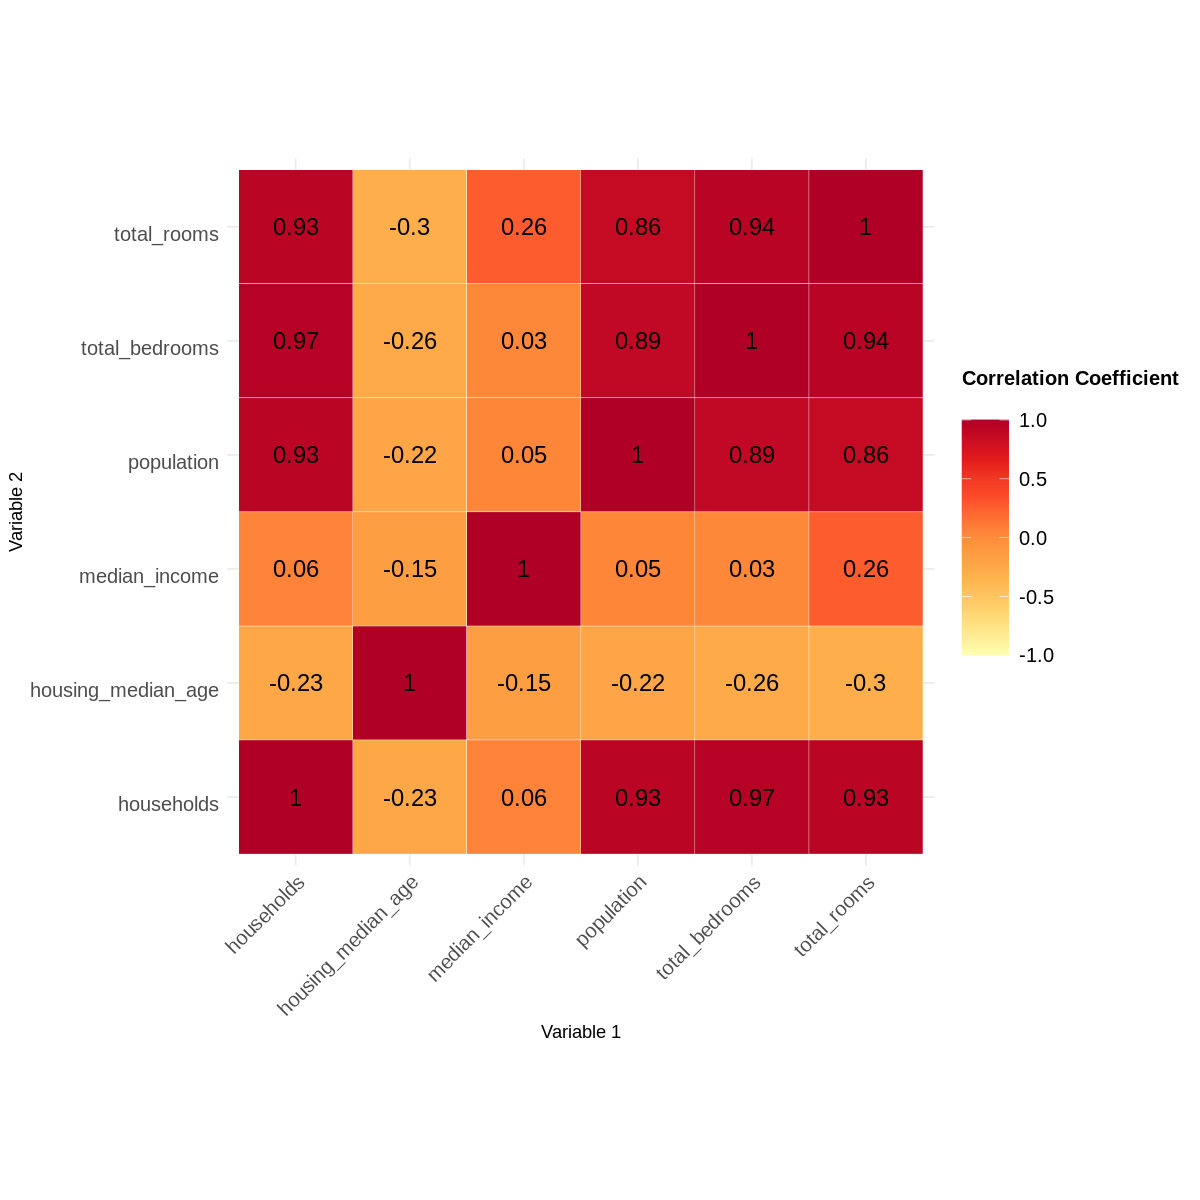

In [54]:
options(repr.plot.width = 10, repr.plot.height = 10)

plot_corr_matrix_housing <- corr_matrix_housing %>%
    ggplot(aes(var1, var2)) +
    geom_tile(aes(fill = corr), color = "white") +
    scale_fill_distiller("Correlation Coefficient \n", palette = "YlOrRd",direction = 1, limits = c(-1,1)) +
    labs(x = "Variable 1", y = "Variable 2") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 12, hjust = 1),
          axis.text.y = element_text(vjust = 1, size = 12, hjust = 1),
          legend.title = element_text(size = 12, face = "bold"),
          legend.text = element_text(size = 12),
          legend.key.size = unit(1, "cm")) +
    coord_fixed() +
    geom_text(aes(var1, var2, label = round(corr, 2)), color = "black", size = 5)

plot_corr_matrix_housing

Observing the above heatmap, we can see that some of the input variables are highly correlated (such as `total_rooms` and `total_bedrooms` which has a correlation coefficient of approximately 0.94), and this will lead to multicollinearity, a problem for the least square estimates of the linear regression coefficients, as well as for their standard errors.

### Model selection

#### Splitting Traning data and Testing data

In [55]:
log_housing$ID <- 1:nrow(log_housing)

housing_train <- 
    slice_sample(log_housing, prop = 0.70) 
 
housing_test <- 
    log_housing %>%
    anti_join(housing_train, by = "ID")
housing_train <- housing_train %>% select(- "ID")
housing_test <- housing_test %>% select(- "ID")
head(housing_train)
nrow(housing_train)
head(housing_test)
nrow(housing_test)

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,2.995732,9.280053,7.388328,8.224432,7.320527,2.2767441,13.12237,<1H OCEAN
2,3.737670,6.935370,5.627621,7.221836,5.564520,1.1977032,11.88173,<1H OCEAN
3,3.828641,7.147559,5.463832,6.350886,5.347108,1.5955824,12.38923,INLAND
4,2.397895,7.832808,6.287859,6.423247,5.594711,1.3545457,12.19653,INLAND
5,2.708050,7.658700,5.963579,6.983790,5.924256,0.8572199,11.29477,INLAND
6,2.890372,7.827640,6.533789,8.048469,6.517671,0.9592736,11.89205,NEAR OCEAN


[1] 14447

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,3.951244,7.290975,5.247024,6.206576,5.176150,1.9820216,12.77167,NEAR BAY
2,3.951244,8.040447,6.532334,7.053586,6.472346,1.1378330,12.39421,NEAR BAY
3,3.951244,8.161375,6.622736,7.315884,6.598509,1.1849429,12.39587,NEAR BAY
4,3.951244,7.315218,5.697093,6.536692,5.616771,0.9567799,12.00089,NEAR BAY
5,3.951244,7.431300,5.820083,6.748760,5.783825,0.7796001,11.50992,NEAR BAY
6,3.891820,7.411556,5.902633,6.625392,5.796058,0.3184537,11.56076,NEAR BAY


[1] 6193

#### Full OLS Model

We use housing_train to build a full OLS model.

In [56]:
housing_full_model<-lm(median_house_value~., data = housing_train)
housing_full_model_results <- tidy(housing_full_model, conf.int = TRUE) %>% mutate_all(~ ifelse(is.numeric(.), round(., 2), .))

In [57]:
housing_full_model_results

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),11.69,0.04,270.06,0,11.61,11.78
(Intercept),11.69,0.04,270.06,0,11.61,11.78
(Intercept),11.69,0.04,270.06,0,11.61,11.78
(Intercept),11.69,0.04,270.06,0,11.61,11.78
(Intercept),11.69,0.04,270.06,0,11.61,11.78
(Intercept),11.69,0.04,270.06,0,11.61,11.78
(Intercept),11.69,0.04,270.06,0,11.61,11.78
(Intercept),11.69,0.04,270.06,0,11.61,11.78
(Intercept),11.69,0.04,270.06,0,11.61,11.78


Then we use predict() and the housing_full_model to obtain the out-of-sample predicted values of median house value in housing_test.

In [58]:
test_housing_full_model <- predict(housing_full_model, newdata = housing_test)
head(test_housing_full_model)

1        2        3        4        5        6 
12.73089 12.37666 12.35584 12.06434 11.91048 11.62044

Now, we compute the root mean square error (RMSE) of housing_test and housing_train respectively. We store the results in a table that has two columns: Model (the name of the regression model) and R_MSE.

In [59]:
housing_R_MSE_pred_models <- tibble(
 Model = "OLS Full Regression(Testing)",
 R_MSE = rmse(
 preds = test_housing_full_model,
 actuals = housing_test$median_house_value))
train_preds <- predict(object = housing_full_model, newdata = housing_train)
train_rmse <- rmse(preds = train_preds, actuals = housing_train$median_house_value)
housing_R_MSE_pred_models <- rbind(housing_R_MSE_pred_models, tibble(Model = "OLS Full Regression (Training)", R_MSE = train_rmse))
housing_R_MSE_pred_models

Model,R_MSE
<chr>,<dbl>
OLS Full Regression(Testing),0.3381489
OLS Full Regression (Training),0.3235234


Then we use 10-fold cross validation to see the performance of housing_full_model.

In [60]:
# define training control
train_control <- trainControl(method="cv", number = 10)

# train the model
model_10CV <- train(median_house_value~., data = housing_train, 
               trControl=train_control, method="lm")

# summarize results
print(model_10CV)

Linear Regression 

14447 samples
    7 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 13001, 13002, 13003, 13003, 13002, 13002, ... 
Resampling results:

  RMSE       Rsquared   MAE      
  0.3238338  0.6753602  0.2446179

Tuning parameter 'intercept' was held constant at a value of TRUE


The RMSE of 10-fold CV is 0.3274079, which is a bit higher than the training RMSE(0.3270176) and a bit lower than the testing RMSE(0.3301665). **The similar RMSE shows that the housing_full_model isn't overfitted and its general performance is good.**

#### Reduced OLS Model Obtained from Forward Selection

In [61]:
housing_forward_sel <- regsubsets(
    x = median_house_value ~., nvmax = 7,
    data = housing_train,
    method = "forward")
housing_forward_summary <- summary(housing_forward_sel)
housing_forward_summary

Subset selection object
Call: regsubsets.formula(x = median_house_value ~ ., nvmax = 7, data = housing_train, 
    method = "forward")
10 Variables  (and intercept)
                          Forced in Forced out
housing_median_age            FALSE      FALSE
total_rooms                   FALSE      FALSE
total_bedrooms                FALSE      FALSE
population                    FALSE      FALSE
households                    FALSE      FALSE
median_income                 FALSE      FALSE
ocean_proximityINLAND         FALSE      FALSE
ocean_proximityISLAND         FALSE      FALSE
ocean_proximityNEAR BAY       FALSE      FALSE
ocean_proximityNEAR OCEAN     FALSE      FALSE
1 subsets of each size up to 7
Selection Algorithm: forward
         housing_median_age total_rooms total_bedrooms population households
1  ( 1 ) " "                " "         " "            " "        " "       
2  ( 1 ) " "                " "         " "            " "        " "       
3  ( 1 ) " "               

In [62]:
housing_fwd_summary <- tibble(
    n_input_variables = 1:7,
    RSS = housing_forward_summary$rss,
    BIC = housing_forward_summary$bic,
    Cp = housing_forward_summary$cp
)
housing_fwd_summary

n_input_variables,RSS,BIC,Cp
<int>,<dbl>,<dbl>,<dbl>
1,2489.061,-9045.08,9319.56752
2,1714.549,-14420.70,1927.45446
3,1702.338,-14514.38,1812.88119
4,1574.849,-15629.40,597.77403
5,1541.405,-15929.93,280.49070
6,1524.427,-16080.36,120.40395
7,1513.236,-16177.24,15.55844


To select the best predictive model, we will look at Mallow's Cp. The most accurate model will have the smallest Cp.

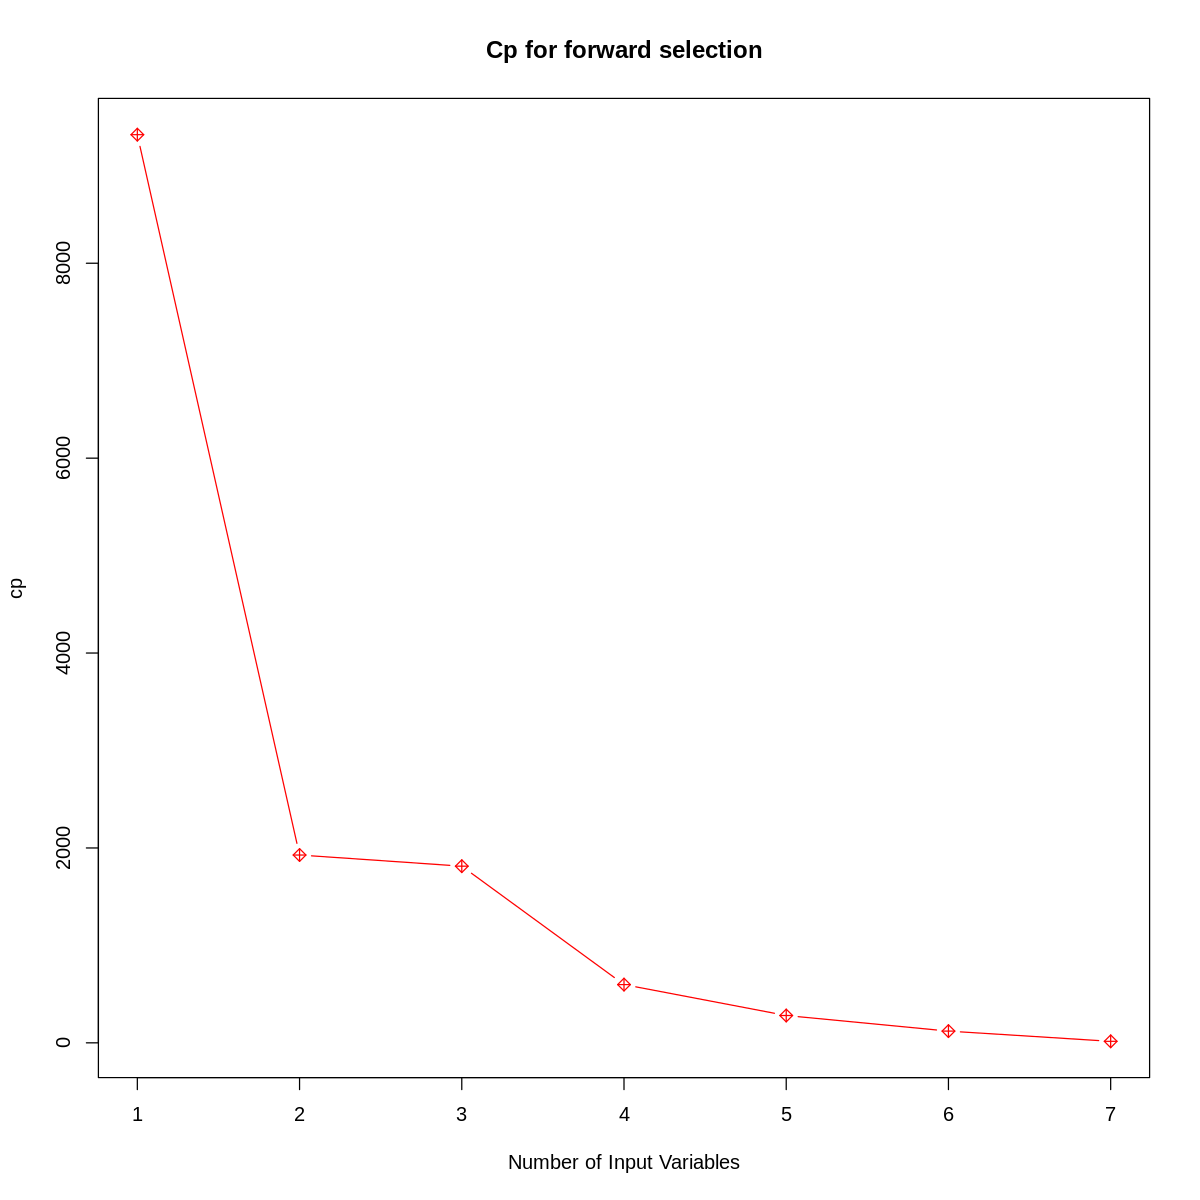

In [63]:
plot(summary(housing_forward_sel)$cp,
 main = "Cp for forward selection",
 xlab = "Number of Input Variables", ylab = "cp", type = "b", pch = 9,
 col = "red"
)

It is not hard to see the value is the lowest when number of input variables is 7, so the most accurate model is the full model.

#### LASSO Model

In [64]:
head(log_housing)

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,3.713572,6.779922,4.859812,5.774552,4.836282,2.119287,13.02276,NEAR BAY,1
2,3.044522,8.867709,7.008505,7.783641,7.037028,2.116424,12.78968,NEAR BAY,2
3,3.951244,7.290975,5.247024,6.206576,5.176150,1.982022,12.77167,NEAR BAY,3
4,3.951244,7.149917,5.459586,6.324359,5.389072,1.730434,12.74052,NEAR BAY,4
5,3.951244,7.394493,5.634790,6.336826,5.556828,1.347086,12.74315,NEAR BAY,5
6,3.951244,6.823286,5.361292,6.023448,5.262690,1.395452,12.50507,NEAR BAY,6


In [65]:
set.seed(123)

# One-Hot Encoding
log_housing <- log_housing %>%
  pivot_wider(names_from = ocean_proximity, values_from = ocean_proximity,
              values_fill = list(ocean_proximity = 0), 
              values_fn = list(ocean_proximity = function(x) as.numeric(length(x) > 0))) 
                               
# To avoid multicollinearity, dropping the most frequency dummy variable
log_housing <- log_housing %>% 
  select(-`<1H OCEAN`)                               

head(log_housing)

housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ID,NEAR BAY,INLAND,NEAR OCEAN,ISLAND
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
3.713572,6.779922,4.859812,5.774552,4.836282,2.119287,13.02276,1,1,0,0,0
3.044522,8.867709,7.008505,7.783641,7.037028,2.116424,12.78968,2,1,0,0,0
3.951244,7.290975,5.247024,6.206576,5.176150,1.982022,12.77167,3,1,0,0,0
3.951244,7.149917,5.459586,6.324359,5.389072,1.730434,12.74052,4,1,0,0,0
3.951244,7.394493,5.634790,6.336826,5.556828,1.347086,12.74315,5,1,0,0,0
3.951244,6.823286,5.361292,6.023448,5.262690,1.395452,12.50507,6,1,0,0,0


In [66]:
lasso_housing_train <-
    slice_sample(log_housing, prop = 0.70)

lasso_housing_test <-
    log_housing %>%
    anti_join(lasso_housing_train, by = "ID")

lasso_housing_train <- lasso_housing_train %>% select(- "ID")
lasso_housing_test <- lasso_housing_test %>% select(- "ID")

head(lasso_housing_train)
nrow(lasso_housing_train)

housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,NEAR BAY,INLAND,NEAR OCEAN,ISLAND
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2.944439,8.213111,6.467699,7.342132,6.338594,1.1394343,11.23980,0,1,0,0
3.610918,8.078068,6.335054,7.189168,6.289716,1.4094736,11.75115,1,0,0,0
3.737670,7.021084,5.541264,6.517671,5.361292,0.4336638,10.58152,0,1,0,0
3.828641,7.642524,5.846439,6.617403,5.869297,1.3996054,12.47610,1,0,0,0
3.295837,8.557375,6.755769,7.767687,6.788972,1.8236779,12.52852,0,0,0,0
3.218876,6.643790,5.273000,6.270988,5.214936,1.1553076,11.79660,0,0,0,0


[1] 14447

In [67]:
head(lasso_housing_test)
nrow(lasso_housing_test)

housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,NEAR BAY,INLAND,NEAR OCEAN,ISLAND
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.951244,7.290975,5.247024,6.206576,5.176150,1.9820216,12.77167,1,0,0,0
3.951244,8.040447,6.532334,7.053586,6.472346,1.1378330,12.39421,1,0,0,0
3.951244,8.161375,6.622736,7.315884,6.598509,1.1849429,12.39587,1,0,0,0
3.951244,7.798113,6.293419,6.922644,6.169611,0.5452271,11.64308,1,0,0,0
3.951244,7.431300,5.820083,6.748760,5.783825,0.7796001,11.50992,1,0,0,0
3.891820,7.411556,5.902633,6.625392,5.796058,0.3184537,11.56076,1,0,0,0


[1] 6193

Fit the LASSO Model with Cross-Validation

In [68]:
lasso_y_train <- lasso_housing_train$median_house_value
lasso_x_train <- as.matrix(lasso_housing_train %>% select(-median_house_value))

lasso_y_test <- lasso_housing_test$median_house_value
lasso_x_test <- as.matrix(lasso_housing_test %>% select(-median_house_value))

# Fit the LASSO model using cross-validation
cv_lasso <- cv.glmnet(lasso_x_train, lasso_y_train, alpha = 1) # alpha = 1 for LASSO

Plot the cross-validation curve

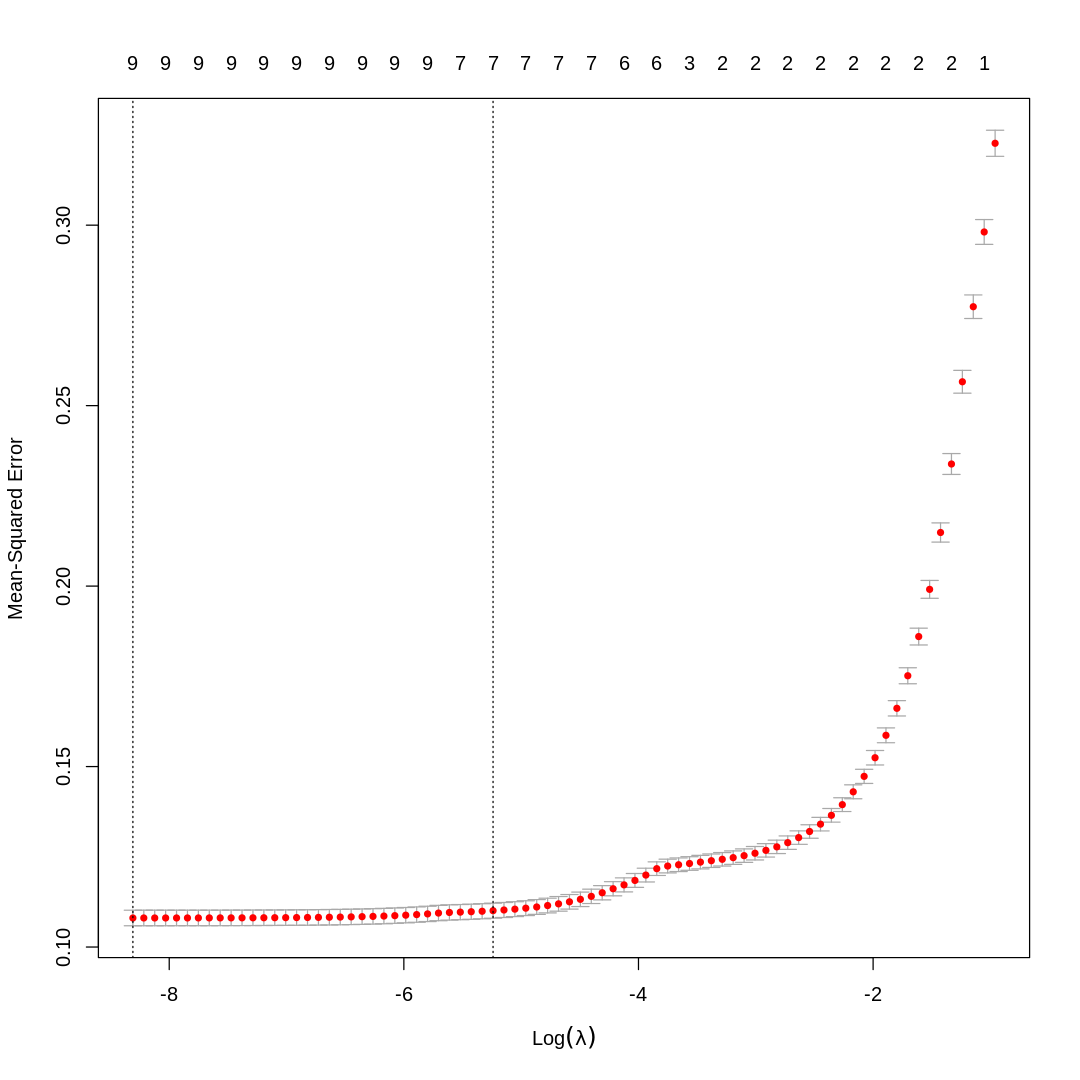

In [69]:
options(repr.plot.width = 9, repr.plot.height = 9)

plot(cv_lasso)

The plot shows the relationship between the logarithm of the lambda regularization parameter and the mean squared error (MSE) from a cross-validated LASSO regression, with the lowest MSE at the optimal lambda indicated by the dotted vertical line.

Make Predictions on Test Data

In [70]:
lasso_pred <- predict(cv_lasso, s = "lambda.min", newx = lasso_x_test)

Advanced Model Evaluation
- Evaluate the model using various metrics like MSE, MAE, or R-squared.
- Consider using bootstrapping or other resampling techniques for a more robust evaluation.

In [71]:
mse <- mean((lasso_pred - lasso_y_test)^2)
mae <- mean(abs(lasso_pred - lasso_y_test))
r_squared <- cor(lasso_y_test, lasso_pred)^2

results <- data.frame(
  Metric = c("MSE", "MAE", "R-squared"),
  Value = c(mse, mae, r_squared)
)

# Printing the results table
print(results)

     Metric     Value
1       MSE 0.1072038
2       MAE 0.2443336
3 R-squared 0.6715974


#### **Interpretation of the results**

The MSE and MAE values are relatively low, likely due to the logarithmic transformation applied to all numerical variables, including the response variable. This transformation often stabilizes variance and normalizes the distribution, improving model performance. An R-squared value of 0.6716 indicates the model explains about 66.94% of the variability in the transformed median house values, which is a reasonably good fit for many practical applications. However, interpreting these results in the original scale of house values requires back-transforming predictions, which should be considered in further analysis and interpretation.

## Reference

Shi, Dequn, et al. “The effects of Park and sea landscape on property value in a tourist city.” Frontiers in Environmental Science, vol. 10, 2022, https://doi.org/10.3389/fenvs.2022.967094. 

Toussaint-Comeau, Maude, and Jin Man Lee. “Determinants of Housing Values and Variations in Home Prices Across Neighborhoods in Cook County.” Determinants of Housing Values and Variations in Home Prices across Neighborhoods in Cook County - Federal Reserve Bank of Chicago, 2018, www.chicagofed.org/publications/profitwise-news-and-views/2018/determinants-of-housing-values-and-variations-in-home-prices-across-neighborhoods-in-cook-county.

##### Dataset

Nugent, C. (2017). California Housing Prices, Version 1. Retrieved October 27, 2023 from https://www.kaggle.com/datasets/camnugent/california-housing-prices/data.